#Double Deep Q-Learning 
---
In the previous notebook we were using additional neural network `target neural network` to estimate $TD_{target}$ according to the formula: 
$$TD_{target} = R + \gamma \max\limits_{a'} Q(S_{t+1}, \argmax\limits_{a'}Q(S_{t+1}, a', w^-), w^-)$$ 
In other words, we were using target neural network to select the best action $a'$, and then we were using the same network to estimate the value of this action. Such an approach can be prone to overestimation. 
To solve this problem, we may select the best action using other set of weights, and then estimate the value of this action with target neural network. In fact, we already have additonal set of weights $w$ that comes from the `local neural network`, so our $TD_{target}$ estimations can be performed as follows:
$$TD_{target} = R + \gamma \max\limits_{a'} Q(S_{t+1}, \argmax\limits_{a'}Q(S_{t+1}, a', w^-), w)$$ 


In [1]:
# Import packages
import gym
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ('Device:', device)

Device: cuda:0


In [2]:
env = gym.make(config.ENVIRONMENT)

In [3]:
from lib.double_dql_agent import Agent

agent = Agent(
    state_size=env.observation_space.shape[0], 
    action_size=env.action_space.n,
    device=device)



In [6]:
def train_agent(n_episodes=config.MAX_EPISODES, 
        max_t=config.MAX_TIMESTEPS, 
        eps_start=config.EPSILON_START, 
        eps_end=config.EPSILON_END, 
        eps_decay=config.EPSILON_DECAY,
        expected_reward = config.EXPECTED_REWARD,
        update_target_every = 4
):
    """Deep Q-Learning.
    Args:
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for 
            epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): decay factor (per episode) 
            for decreasing epsilon
        expected_reward (float): finish when the average score
            is greater than this value
        upate_target_every (int): how often should the target 
            network be updated. Default: 1 (per every episode) 
    Returns:
        scores (list): list of scores from each episode
    """
    scores = []                        
    scores_window = deque(maxlen=100)  
    eps = eps_start                    
    for episode in range(1, n_episodes+1):
        state, info = env.reset()
        score = 0
        for t in range(max_t):
            
            action = agent.act(state, eps)
            next_state, reward, done, truncated, info = env.step(action)
            
            agent.step(state, action, reward, next_state, done)
            
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       
        scores.append(score)
                
        eps = max(eps_end, eps_decay*eps) 
        
        if episode % update_target_every == 0:
            agent.target_hard_update()
        
        mean_score = np.mean(scores_window)
        print(f'\rEpisode {episode}\tAverage Score: {mean_score:.2f}', end="")
        if episode % 100 == 0:
            print(f'\rEpisode {episode}\tAverage Score: {mean_score:.2f}')
            agent.save('checkpoint.pth')
        if mean_score >= expected_reward:
            print(f'\nDone in {episode:d} episodes!\tAverage Score: {mean_score:.2f}')
            agent.save('checkpoint.pth')
            break
    return scores

### Train the agent


Episode 100	Average Score: 17.94
Episode 200	Average Score: 13.06
Episode 300	Average Score: 38.88
Episode 400	Average Score: 139.86
Episode 438	Average Score: 230.94
Done in 438 episodes!	Average Score: 230.94


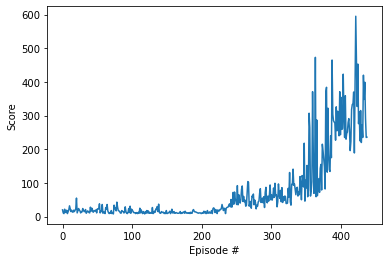

In [7]:
scores = train_agent()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()